In [65]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import r2_score
import pickle
from bayesian_logistic_regression import BayesianLogisticRegression
from mlp import MLP
from mlba_nn import MLBA_NN
import json

In [66]:
features = ['Rect1Height', 'Rect1Width', 'Rect2Height', 'Rect2Width', 'Rect3Height', 'Rect3Width']
train_data = pd.read_csv('data/E2.csv')
# train_data = pd.read_csv('data/synth/synth_100_100_labeled.csv')
e1a = pd.read_csv('data/E1a.csv')
e1b = pd.read_csv('data/E1b.csv')
e1c = pd.read_csv('data/E1c.csv')


# fine_tune_data = pd.read_csv('data/E2.csv')
# usernames = fine_tune_data.username.unique()
# usernames.sort()
# secondHalf = usernames[32]
# fine_tune_data = fine_tune_data[fine_tune_data.username >= secondHalf]
# fine_tune_data

## Train a model

In [67]:
X_train = train_data[features].values
y_train = train_data.response.values - 1
# model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# model = RandomForestClassifier(n_estimators=100)
# model = tree.DecisionTreeClassifier(max_depth=5)
# model = SVC(probability=True, gamma='auto')
# model = BayesianLogisticRegression(10000)
# model = MLP(6, 3, 50, 100, 32)
model = MLBA_NN(6, 3, 50, 100, 32)
model = model.fit(X_train, y_train)
# model.save('bayes_logistic.pkl')
# model.load('bayes_logistic.pkl')

Thu Sep  3 17:31:19 2020 >  Epoch     5 - Train Loss:     1.043640, val Loss:   1.040702, Best:   1.040702
Thu Sep  3 17:31:24 2020 >  Epoch    10 - Train Loss:     1.034240, val Loss:   1.030786, Best:   1.030786
Thu Sep  3 17:31:28 2020 >  Epoch    15 - Train Loss:     1.022894, val Loss:   1.017666, Best:   1.017666
Thu Sep  3 17:31:32 2020 >  Epoch    20 - Train Loss:     1.020231, val Loss:   1.016472, Best:   1.016366
Thu Sep  3 17:31:36 2020 >  Epoch    25 - Train Loss:     1.018853, val Loss:   1.014409, Best:   1.014409
Thu Sep  3 17:31:40 2020 >  Epoch    30 - Train Loss:     1.018021, val Loss:   1.013371, Best:   1.013371
Thu Sep  3 17:31:44 2020 >  Epoch    35 - Train Loss:     1.017353, val Loss:   1.013469, Best:   1.013371
Thu Sep  3 17:31:48 2020 >  Epoch    40 - Train Loss:     1.016837, val Loss:   1.012627, Best:   1.012627
Thu Sep  3 17:31:53 2020 >  Epoch    45 - Train Loss:     1.016652, val Loss:   1.012927, Best:   1.012551
Thu Sep  3 17:31:57 2020 >  Epoch    

In [68]:
# X = fine_tune_data[features].values
# y = fine_tune_data.response.values - 1
# model.lr = 0.0001
# model.epochs = 50
# model = model.fit(X, y)

## Results

In [69]:
def get_freq(x):
    hist, _ = np.histogram(x, 3)
    return hist/hist.sum()
    
def predict(model, data):
    X_test = data[features].values
    y_test = data.response.values - 1
    actual_freq = get_freq(y_test)
    pred_freq = model.predict_proba(X_test).mean(0) # get_freq(pred)
    return actual_freq, pred_freq, ((actual_freq - pred_freq) ** 2).mean()

In [70]:
def get_predictions(model, data):
    MSE = []
    actual = []
    pred = []
    for d in data:
        actual_freq, pred_freq, mse = predict(model, d)
        MSE.append(mse)
        actual.append(actual_freq)
        pred.append(pred_freq)
#         print(actual_freq, pred_freq, mse)

    actual = np.array(actual)
    pred = np.array(pred)
    return actual, pred, MSE

In [71]:
markers = ['o', '^', 'd', 's', '.', '*', 'x', 'p', 'h', 'v']
colors = ['r', 'lime', 'b']
def plot_results(actual, pred, c=1):
    plt.figure(figsize=[4.8, 4.8])
    for i in range(3):
        x, y = actual[:, i], pred[:, i]
        for j in range(len(x)):
            plt.scatter(x[j], y[j], marker=markers[i], c=colors[c])
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.plot([0, 1], [0, 1])
    plt.xlim(0, 1)
    plt.ylim(0, 1)

### Train Results

[0.0002421115628144964,
 3.0112416048048446e-06,
 0.0001719385758217456,
 1.5116784182363936e-05,
 0.00012868043580034595,
 4.5947548122116745e-05]

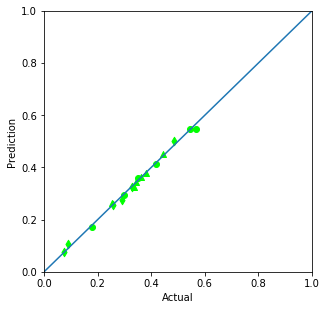

In [72]:
train_effects = [d for _, d in train_data.groupby('Effect')]
actual, pred, mse = get_predictions(model, train_effects)
plot_results(actual, pred)
mse

### Test results

#### Attraction

0.004481545547054575

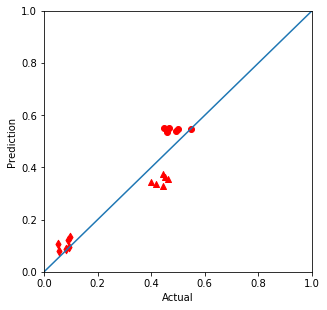

In [73]:
e1a_effects = [d for _, d in e1a.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1a_effects])
plot_results(actual, pred, 0)
np.mean(mse)

#### Compromise

0.0018165195385621267

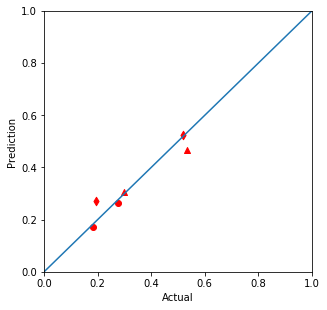

In [74]:
e1b_effects = [d for _, d in e1b.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1b_effects])
plot_results(actual, pred, 0)
np.mean(mse)

#### Similarity

0.002564115745769661

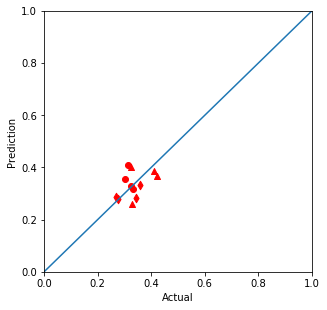

In [75]:
e1c_effects = [d for _, d in e1c.groupby('Effect')]
actual, pred, mse = get_predictions(model, [*e1c_effects])
plot_results(actual, pred, 0)
np.mean(mse)

# Paper results

In [76]:
cols = ['Cond', 'Time', 'Resp.O1', 'Resp.O2', 'Resp.O3']
def load_paper_data(path):
    with open(path) as f:
        data = json.load(f)
    data = [[s[k] for k in cols] for u in data for s in u]
    data = pd.DataFrame(data=data, columns=cols)
    return data.rename(columns={'Cond': 'Effect'})

experimentData = {
    'e1a': (e1a, load_paper_data('out/e1a.pred-half.json')),
    'e1b': (e1b, load_paper_data('out/e1b.pred-half.json')),
    'e1c': (e1c, load_paper_data('out/e1c.pred-half.json')),
}

In [77]:

def get_paper_predictions(exp):
    actual, pred = experimentData[exp]    
    actual = [[k ,get_freq(d.response.values - 1)] for k, d in actual.groupby('Effect')]
    pred = [[k, d[['Resp.O1', 'Resp.O2', 'Resp.O3']].values.mean(0)] for k, d in pred.groupby('Effect')]
    actual = np.array([e[1] for e in sorted(actual, key=lambda x: x[0])])
    pred = np.array([e[1] for e in sorted(pred, key=lambda x: x[0])])
    mse = ((actual - pred) ** 2).mean(1)
    return actual, pred, mse.tolist()

#### Attraction

0.01125967844681576

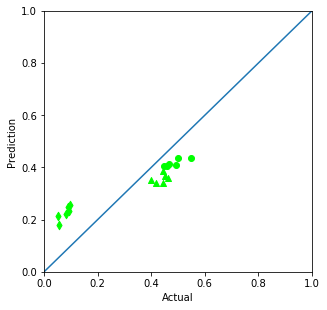

In [78]:
actual, pred, mse = get_paper_predictions('e1a')
plot_results(actual, pred)
np.mean(mse)

#### Compromise

0.019194272098289354

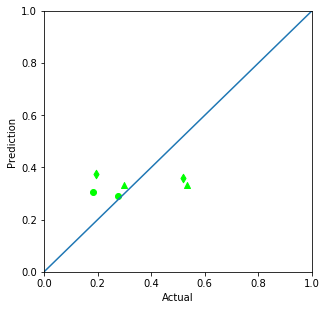

In [79]:
actual, pred, mse = get_paper_predictions('e1b')
plot_results(actual, pred)
np.mean(mse)

#### Similarity

0.001977373070890172

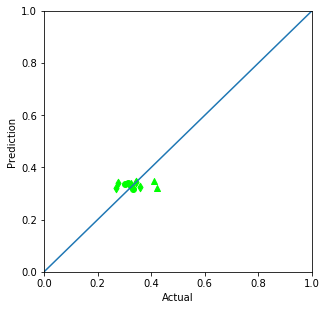

In [80]:
actual, pred, mse = get_paper_predictions('e1c')
plot_results(actual, pred)
np.mean(mse)